In [1]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from model_class_pytrch import Model_class
gpu_id = 2
!nvidia-smi

Sat Jul 24 23:53:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   24C    P8     8W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   23C    P8     7W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
my_path = '../../dataset/sharma_59_nih_dataset/anotherdataset/'
path_0 = my_path+'mask/'
path_1 = my_path + 'nomask/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[4300,627,400])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

# root_dir = 'LatestSavedModels/'


2635
2692
{'mask': 0, 'nomask': 1}


In [4]:
img,labels = next(iter(train_loader))

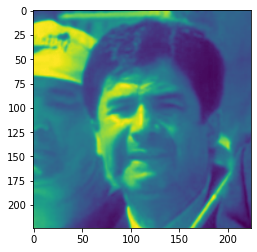

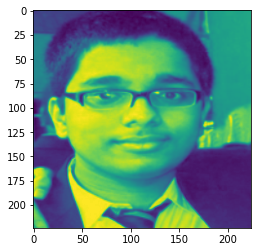

In [6]:
plt.imshow(img[1][0])
plt.show()
plt.imshow(img[3][0])
plt.show()

In [8]:
torch.unique(labels,return_counts=True)

(tensor([0, 1]), tensor([30, 34]))

In [9]:
mob_v2 = torchvision.models.mobilenet_v2(pretrained=True)
mob_v2.classifier[0] = nn.Dropout(p=0.3)
mob_v2.classifier[1] = nn.Linear(in_features=1280,out_features=2)
print(mob_v2)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [10]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=mob_v2.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
n_epochs=20
model = Model_class(mob_v2,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 2226434

one of the best validation acc found
epoch:[1/20],memory:[2.610525608062744/10.91650390625], lr:[0.0003]
train_accuracy:0.9944852941176471, train_loss:0.05915299631134771
val_acc:0.9984375,val_loss:0.009276667219819502

epoch:[2/20],memory:[2.6342625617980957/10.91650390625], lr:[0.0003]
train_accuracy:1.0, train_loss:0.0035640490855525166
val_acc:0.9984375,val_loss:0.006719033076660707

epoch:[3/20],memory:[2.6342625617980957/10.91650390625], lr:[0.0003]
train_accuracy:0.9997702205882353, train_loss:0.005379097072096449
val_acc:0.99375,val_loss:0.022130500138155186

epoch:[4/20],memory:[2.6342625617980957/10.91650390625], lr:[0.0003]
train_accuracy:0.9997702205882353, train_loss:0.0037671489515774094
val_acc:0.996875,val_loss:0.004124717060039984

epoch:[5/20],memory:[2.6342625617980957/10.91650390625], lr:[0.0003]
train_accuracy:1.0, train_loss:0.0027863408295161207
val_acc:0.9984375,val_loss:0.005414389287761878

epoch:[6/20],memory:[2.63426

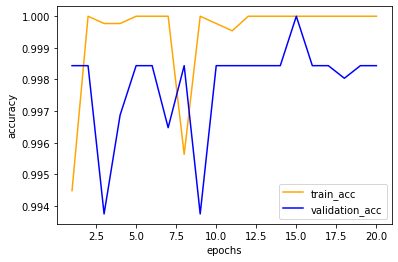

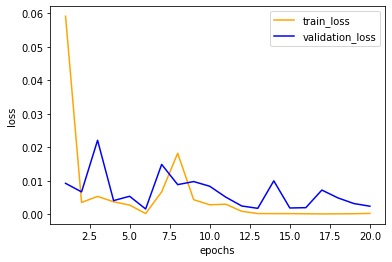

In [11]:
model.accuracy_curve()
model.loss_curve()

correct are 4300/4300
tensor(1.)


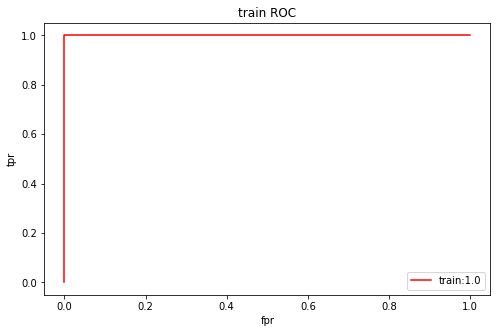

correct are 400/400
tensor(1.)


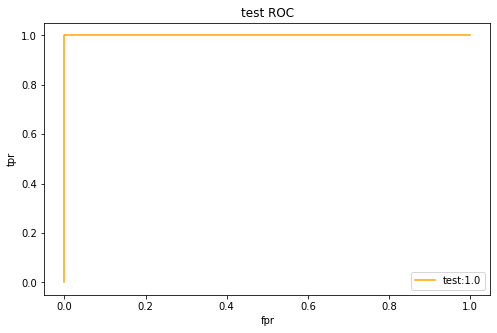

In [12]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


In [13]:
message = {'model':"mobilenet_v2",'train':1,'test':1}
print(dir(model))

['Normalize', 'Normalize_train', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'accuracy_curve', 'auc_', 'best_model', 'best_optimizer', 'best_valid_acc', 'evaluate', 'evaluate_batch', 'fpr', 'gpu_id', 'loss_curve', 'model', 'n_epochs', 'plot_precision_recall', 'plot_roc', 'print_params', 'save_best_model', 'save_model', 'tpr', 'train', 'train_acc', 'train_loss', 'val_acc', 'val_loss']


In [14]:
model.save_model('mask_classification_v1.pth',message)

model saved
